# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
%matplotlib inline

# if torch.cuda.is_available():
#     device = torch.device('cuda:0')
# else:
device = torch.device('cpu')


In [2]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder=False):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.autoencoder = autoencoder

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]

        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)

            if self.autoencoder:
                array = array.reshape(self.height*self.width)
            else:
                array = array.reshape(1,self.height,self.width)

            image_array.append(array)

        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]

    def __repr__(self):
        return str(self.dataframe.head())


In [3]:
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir)
print(dataset)


                                         image  labels
0    ../../../data/brain_tumor_imgs/yes\Y3.jpg       1
1  ../../../data/brain_tumor_imgs/yes\Y169.jpg       1
2   ../../../data/brain_tumor_imgs/yes\Y42.jpg       1
3  ../../../data/brain_tumor_imgs/yes\Y167.JPG       1
4   ../../../data/brain_tumor_imgs/yes\Y95.jpg       1


In [4]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 256, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(256,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(62,128)
        self.linear2 = self.torch_ref.nn.Linear(128,64)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(126976,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        x = self.torch_ref.nn.functional.relu(self.conv2(x))
        x = self.torch_ref.nn.functional.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x


In [5]:
model = BrainTumorModel(torch_ref=torch)
# model.to(device)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [7]:
epochs = 100
batch_size = 32
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(dataset)//batch_size):

        data,target = dataset[n*batch_size:(n+1)*batch_size]

        ypred = model.forward(data.float())
        loss = loss_fn(ypred,target)

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(total_loss/batch_size)
    if epoch%10 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

Epochs: 0 Loss: 30.111984252929688
Epochs: 10 Loss: 0.744563102722168
Epochs: 20 Loss: 0.6298296451568604
Epochs: 30 Loss: 0.5677100419998169
Epochs: 40 Loss: 0.4226228892803192
Epochs: 50 Loss: 0.2149839848279953
Epochs: 60 Loss: 0.13247829675674438
Epochs: 70 Loss: 0.08095231652259827
Epochs: 80 Loss: 0.06013920530676842
Epochs: 90 Loss: 0.05080116167664528


In [31]:
type(loss_list[0])

# fig = plt.figure(figsize=(10,10))
# plt.plot(list(range(epochs)),loss_list)
# plt.title("Loss v/s Epochs")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()

torch.Tensor

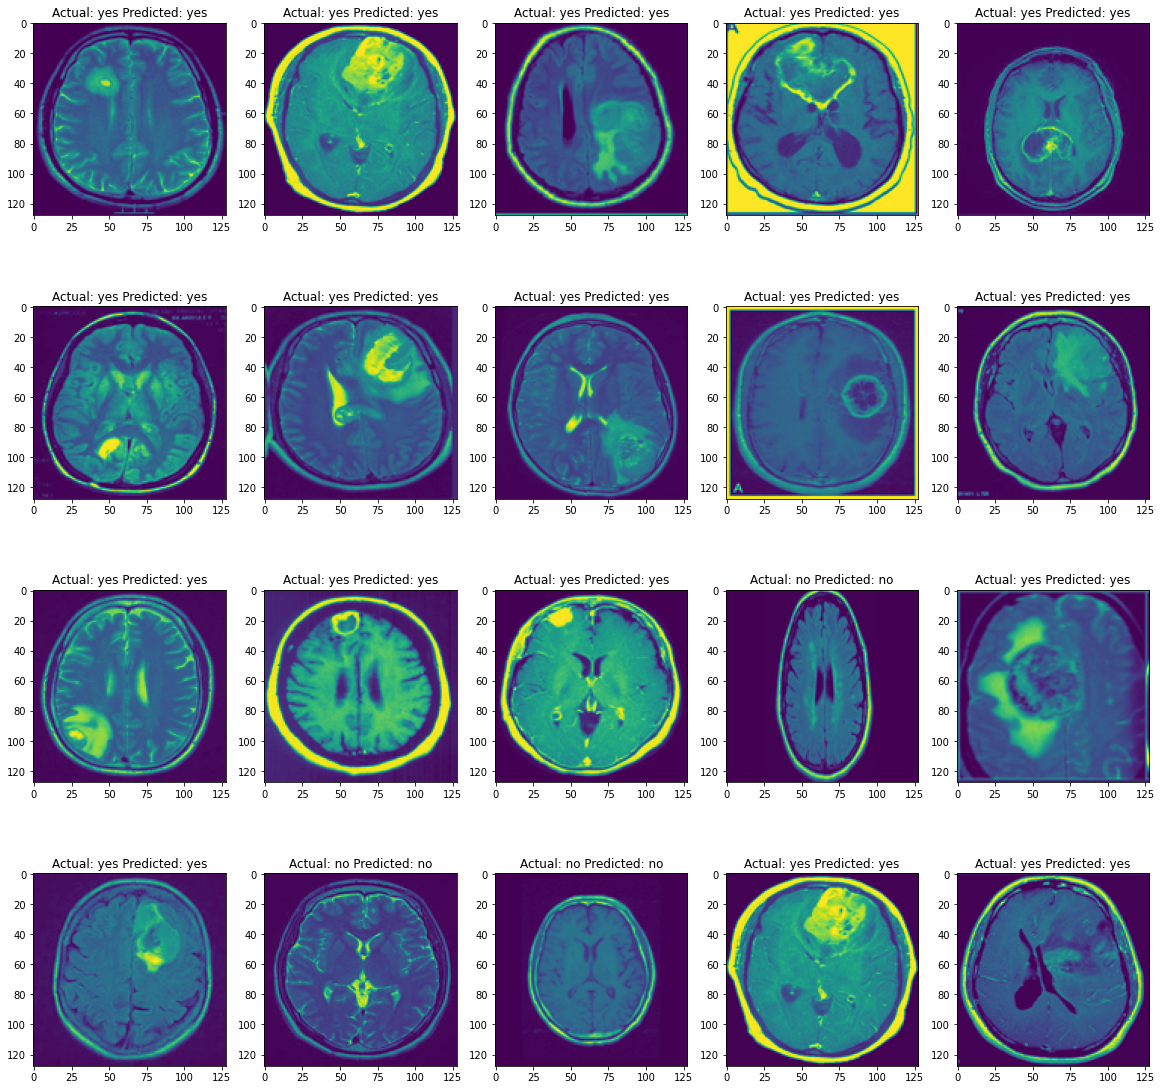

In [8]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
for i in range(20):
    data,target = dataset[i]
    pred = model.forward(data.float())
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()

RuntimeError: expected scalar type Byte but found Float

In [9]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon


In [15]:
dataset[13][1]


tensor(0)

In [16]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    data_pointers = []

    split_size = int(len(data)/len(session.parties))+1
    for index in range(0,len(session.parties)):
        ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        data_pointers.append(ptr)

    return data_pointers

In [18]:
brain_tumor_data_loader = torch.utils.data.DataLoader(dataset,
                                                      batch_size=32,
                                                      shuffle=True)

[tensor([[[[[  6,  14,  13,  ...,  16,  13,  13],
            [  5,  12,  13,  ...,  14,  13,  13],
            [  5,  11,  12,  ...,  15,  16,  14],
            ...,
            [  5,  10,  12,  ...,  14,  15,  14],
            [  5,  11,  13,  ...,  14,  13,  12],
            [  7,  13,  13,  ...,  11,  11,  13]]]],
 
 
 
         [[[[  1,   1,   1,  ...,   1,   1,   1],
            [  1,   1,   1,  ...,   1,   1,   1],
            [  1,   1,   1,  ...,   1,   1,   1],
            ...,
            [  1,   1,   1,  ...,   1,   1,   1],
            [  1,   1,   1,  ...,   1,   1,   1],
            [  1,   1,   1,  ...,   1,   1,   1]]]],
 
 
 
         [[[[  1,   1,   1,  ...,   1,   1,   1],
            [  1,   1,   1,  ...,   1,   1,   1],
            [  1,   1,   1,  ...,   1,   1,   1],
            ...,
            [  1,   1,   1,  ...,   1,   1,   1],
            [  1,   1,   1,  ...,   1,   1,   1],
            [  1,   1,   1,  ...,   1,   1,   1]]]],
 
 
 
         ...,
 
 
 
  

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [256, 1, 3, 3], but got 5-dimensional input of size [32, 1, 1, 128, 128] instead

In [21]:
import time
def inference(n_clients, model, protocol=None):

  # Get VM clients
  parties=get_clients(n_clients)

  # Setup the session for the computation
  if(protocol):
     session = Session(parties = parties,protocol = protocol)
  else:
     session = Session(parties = parties)

  SessionManager.setup_mpc(session)

  #Split data and send data to clients
  imgs, labels = next(iter(brain_tumor_data_loader))
  actual_labels = labels[:20].numpy()
  pointers = split_send(imgs[:20],session)

  print(session)
  #Encrypt model
  mpc_model = model.share(session)

  #Encrypt test data
  #test_data=MPCTensor(secret=test_x, session = session)

  #Perform inference and measure time taken
  start_time = time.time()

  results = []

  for ptr in pointers:
     encrypted_results = mpc_model(ptr)
     plaintext_results = encrypted_results.reconstruct()
     results.append(plaintext_results)

  end_time = time.time()

  print(f"Time for inference: {end_time-start_time}s")


  predictions = []
  for pred in results:
      predictions.append(torch.max(pred,1)[1].data.numpy().squeeze())



  print(f'Prediction number: {predictions[0]}')
  print(f'Actual number: {actual_labels}')
  print(predictions)

  return predictions

predictions=inference(3, model)


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [256, 1, 3, 3], but got 5-dimensional input of size [7, 1, 1, 128, 128] instead

In [60]:
predictions=inference(3, model)


TypeError: share() missing 1 required positional argument: 'session'

In [59]:
session = Session(get_clients(3))
SessionManager.setup_mpc(session)
mpc_model = model.share(session)

